Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 116.04it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 10
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 4


# save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'

for num_user in num_users:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    # Test performance of aggregator on data 
    aggregator.load_state(dir_path=save_path_FAT)
    aggregator.update_clients()
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()

    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_og, model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
    #  Assign proportion and attack params
    if True:
        for c in aggregator.clients:
            c.unlearning_flag = True
            
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%1 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_og, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_
    gc.collect()
    torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..


  0%|          | 0/80 [00:00<?, ?it/s]


===> Initializing clients..


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


round 0 Test acc:  0.8043750002980232 ( 0.06334121691144534 ) adv acc:  0.4249999962747097 ( 0.11401753808272846 )


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 1 Test acc:  0.8043749958276749 ( 0.06468372215881805 ) adv acc:  0.3793749988079071 ( 0.09068101599515453 )
round 2 Test acc:  0.6925000011920929 ( 0.0806128843023888 ) adv acc:  0.27468750029802325 ( 0.06757446774332633 )
round 3 Test acc:  0.5409375041723251 ( 0.07357964936152064 ) adv acc:  0.16874999944120644 ( 0.050543916414300914 )
round 4 Test acc:  0.453437502682209 ( 0.09370780381949673 ) adv acc:  0.14000000148080288 ( 0.05563553323211172 )
round 5 Test acc:  0.46281250193715096 ( 0.09776756140324405 ) adv acc:  0.15531249986961485 ( 0.06488496330343078 )
round 6 Test acc:  0.47124999687075614 ( 0.10647769638529561 ) adv acc:  0.1578124992083758 ( 0.074565798861035 )
round 7 Test acc:  0.4709374994039536 ( 0.12088177105585661 ) adv acc:  0.1587499993853271 ( 0.06621461099340752 )
round 8 Test acc:  0.48093749657273294 ( 0.10554869972682282 ) adv acc:  0.16593749802559615 ( 0.06626105295317336 )
round 9 Test acc:  0.4718749962747097 ( 0.11554050916706589 ) adv acc:  0.1

  2%|▎         | 2/80 [00:00<00:00, 114.66it/s]


===> Initializing clients..


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


round 0 Test acc:  0.8062500014901162 ( 0.062437469583846425 ) adv acc:  0.4353125013411045 ( 0.10034656665491831 )
round 1 Test acc:  0.5053125023841858 ( 0.09265559153620467 ) adv acc:  0.1225000003585592 ( 0.0514781500608738 )
round 2 Test acc:  0.47437500208616257 ( 0.08187022899830154 ) adv acc:  0.13187500080093742 ( 0.04097922534189644 )
round 3 Test acc:  0.5868750058114529 ( 0.07935039131634258 ) adv acc:  0.17562499847263097 ( 0.04904955906694194 )
round 4 Test acc:  0.5837500035762787 ( 0.08024376728332797 ) adv acc:  0.14343749983236193 ( 0.040018306248896955 )
round 5 Test acc:  0.6046875014901161 ( 0.08522431528065519 ) adv acc:  0.15437499899417162 ( 0.0572514989853472 )
round 6 Test acc:  0.6096874997019768 ( 0.07523335941293875 ) adv acc:  0.1450000001117587 ( 0.04895788975693942 )
round 7 Test acc:  0.5953125029802322 ( 0.07963233289861577 ) adv acc:  0.1428125010803342 ( 0.03921968350062962 )
round 8 Test acc:  0.5950000010430813 ( 0.07266146001286634 ) adv acc:  0.1

  5%|▌         | 4/80 [00:00<00:00, 106.80it/s]


===> Initializing clients..


100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


round 0 Test acc:  0.7999999970197678 ( 0.0657290826520894 ) adv acc:  0.41874999962747095 ( 0.11639103907293115 )
round 1 Test acc:  0.6609374985098839 ( 0.0746443388623176 ) adv acc:  0.20781249850988387 ( 0.04699463866247273 )
round 2 Test acc:  0.6115624994039536 ( 0.08972124503101897 ) adv acc:  0.17218750063329935 ( 0.045456666787203094 )
round 3 Test acc:  0.6637500032782555 ( 0.05881645215378672 ) adv acc:  0.19218750093132259 ( 0.04327306927504573 )
round 4 Test acc:  0.6674999967217445 ( 0.07047827644619609 ) adv acc:  0.1799999989569187 ( 0.04943429826199028 )
round 5 Test acc:  0.665625 ( 0.056023848553802866 ) adv acc:  0.1681249998509884 ( 0.04011214689152936 )
round 6 Test acc:  0.6615624994039535 ( 0.06779953583551057 ) adv acc:  0.15843749996274709 ( 0.04140005774209405 )
round 7 Test acc:  0.6809375002980232 ( 0.06072398095788913 ) adv acc:  0.16218750067055226 ( 0.03927939758462872 )
round 8 Test acc:  0.6781249985098838 ( 0.06695088824861563 ) adv acc:  0.1587500000

 11%|█▏        | 9/80 [00:00<00:00, 145.20it/s]


===> Initializing clients..


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


round 0 Test acc:  0.8090625002980232 ( 0.06737184043094029 ) adv acc:  0.43281249664723875 ( 0.10693483044614704 )
round 1 Test acc:  0.7096875004470349 ( 0.08317374076079685 ) adv acc:  0.2446874998509884 ( 0.06500525874735011 )
round 2 Test acc:  0.6412499986588955 ( 0.06411659045096808 ) adv acc:  0.19406249970197678 ( 0.05031055787844369 )
round 3 Test acc:  0.6684374995529652 ( 0.07336698636901494 ) adv acc:  0.20812499932944775 ( 0.05112408180701319 )
round 4 Test acc:  0.7031250014901161 ( 0.07393779116625404 ) adv acc:  0.21062499955296515 ( 0.06043785414073009 )
round 5 Test acc:  0.6978125035762787 ( 0.0719639386108411 ) adv acc:  0.1668750002980232 ( 0.04450684633322907 )
round 6 Test acc:  0.7146874949336052 ( 0.07399786087955558 ) adv acc:  0.1874999986961484 ( 0.05092887089888484 )
round 7 Test acc:  0.7015624970197678 ( 0.06668416291767895 ) adv acc:  0.17218749988824128 ( 0.03907999522770536 )
round 8 Test acc:  0.7087500035762787 ( 0.06668489421322725 ) adv acc:  0.17

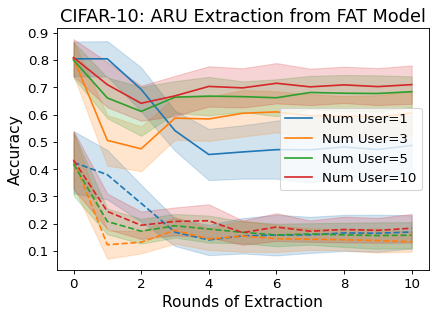

In [11]:

# Initialize a new figure
plt.figure(figsize=(6, 4), dpi=80)

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 11, 1)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('CIFAR-10: ARU Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()